In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do Support Vector Regression (SVR) to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [4]:
hourly_nighlty_threshold = 50

# Support Vector Regression (SVR) Analysis Of Solar and Weather



In [5]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [6]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

In [7]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [8]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [9]:

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Save test and training x and y to feather files
# This allows later analysis without needing to redo the train test split
X_train.to_pickle(f"{TRAIN_DATA_DIR}/X_train_test_no_{test_no}.pickle")
y_train.to_pickle(f"{TRAIN_DATA_DIR}/y_train_test_no_{test_no}.pickle")
X_test.to_pickle(f"{TRAIN_DATA_DIR}/X_test_test_no_{test_no}.pickle")
y_test.to_pickle(f"{TRAIN_DATA_DIR}/y_test_test_no_{test_no}.pickle")
# Also put test no , name and notes in a dataframe and save as feather
test_info_df = pd.DataFrame({
    "Test No": [test_no],
    "Test Name": [test_name],
    "Notes": [notes],
    'target_col': [target_col],
    'feature_cols': [feature_cols]
})
test_info_df.to_feather(f"{TRAIN_DATA_DIR}/test_info_test_no_{test_no}.pickle")



Testing Random Forest Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
X_train shape: (2192, 18)
y_train shape: (2192,)
X_test shape: (2194, 18)
y_test shape: (2194,)


In [41]:
svr_model = SVR(
    kernel='rbf',         # Radial basis function kernel
    C=1.0,                # Regularization parameter
    epsilon=0.01,          # Epsilon in epsilon-SVR model
    gamma='scale',        # Kernel coefficient
    cache_size=200,        # Kernel cache size in MB
    max_iter=-1           # No limit on iterations
)

# Train the model
print("Fitting model...")
svr_model.fit(X_train, y_train)

# Make predictions
print("Making predictions on test set...")
y_test_pred = svr_model.predict(X_test)
print("Making predictions on test set... Done")

# making predictions on training set
print("Making predictions on training set...")
y_train_pred = svr_model.predict(X_train)
print(f"Target Column {target_col}")

# Depending on target column, inverse transform if necessary
if target_col in ['PV(W)']:
    y_train_pvw_pred = y_train_pred
    y_train_pvw = y_train
    y_test_pvw_pred = y_test_pred
    y_test_pvw = y_test
elif target_col in ['PV(W)_error']:
    y_train_pvw_pred = y_train_pred + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test + X_test['Total_Power_ClearSky_Output(W)']

if target_col in ['Clearsky_Index']:
    y_train_pvw_pred = y_train_pred * X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = y_train * X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = y_test_pred * X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = y_test * X_test['Total_Power_ClearSky_Output(W)']
elif target_col in ['PV(W)_error_index']:
    y_train_pvw_pred = (y_train_pred * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_train_pvw = (y_train * X_train['Total_Power_ClearSky_Output(W)']) + X_train['Total_Power_ClearSky_Output(W)']
    y_test_pvw_pred = (y_test_pred * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']
    y_test_pvw = (y_test * X_test['Total_Power_ClearSky_Output(W)']) + X_test['Total_Power_ClearSky_Output(W)']

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...
Target Column PV(W)_error


__Metrics for Tests 

In [42]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing# # do SVR regression to predict PV(W) from the other columnsfrom sklearn.model_selection import train_test_splitfrom sklearn.svm import SVRfrom sklearn.metrics import mean_squared_error, r2_score# do SVR regression to predict PV(W) from the other columnsfrom sklearn.model_selection import train_test_splitfrom sklearn.svm import SVRfrom sklearn.metrics import mean_squared_error, r2_scoredef calculate_metrics(y_true, y_pred):    rmse = np.sqrt(mean_squared_error(y_true, y_pred))    mae = np.mean(np.abs(y_true - y_pred))    r2 = r2_score(y_true, y_pred)    # and normalized based on MAX of y_true - the standard practice for solar prediction    normalization_factor = np.max(y_true) - np.min(y_true)    #normalization_factor = 8400 # based on max PV(W) based on system size    n_rmse = rmse / normalization_factor    n_mae = mae / normalization_factor    # calculate accuracy as 1 - (mae / mean of y_true)    accuracy_score = 1 - (mae / np.mean(y_true))    return rmse, mae, r2 , n_rmse, n_mae, accuracy_scoretrain_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracymk_string = """| Metric       | Training Set        | Testing Set         ||--------------|---------------------|---------------------|| RMSE         | {:.2f}              | {:.2f}              || MAE          | {:.2f}              | {:.2f}              || R2           | {:.4f}              | {:.4f}              || N-RMSE (%)   | {:.4f}              | {:.4f}              || N-MAE (%)    | {:.4f}              | {:.4f}              || Accuracy (%) | {:.4f}              | {:.4f}              |""".format(    train_rmse, test_rmse,    train_mae, test_mae,    train_r2, test_r2,    train_n_rmse*100, test_n_rmse*100,    train_n_mae*100, test_n_mae*100,    train_accuracy*100, test_accuracy*100)from IPython.display import display, Markdowndisplay(Markdown(f"### SVR Regressor Performance Metrics {target_col}\n" + mk_string))mk_string = """| Metric       | Training Set        | Testing Set         ||--------------|---------------------|---------------------|| RMSE         | {:.2f}              | {:.2f}              || MAE          | {:.2f}              | {:.2f}              || R2           | {:.4f}              | {:.4f}              || N-RMSE (%)   | {:.4f}              | {:.4f}              || N-MAE (%)    | {:.4f}              | {:.4f}              || Accuracy (%) | {:.4f}              | {:.4f}              |""".format(    train_rmse_pvw, test_rmse_pvw,    train_mae_pvw, test_mae_pvw,    train_r2_pvw, test_r2_pvw,    train_n_rmse_pvw*100, test_n_rmse_pvw*100,    train_n_mae_pvw*100, test_n_mae_pvw*100,    train_accuracy_pvw*100, test_accuracy_pvw*100)from IPython.display import display, Markdowndisplay(Markdown(f"### SVR Regressor Performance Metrics PV(W)\n" + mk_string))

In [43]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score


# do XBOOST regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    # Calculate Explained Variance
    explained_var = explained_variance_score(y_true, y_pred)
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score, explained_var
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy, train_explained_var = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy, test_explained_var = calculate_metrics(y_test, y_test_pred)
train_rmse_pvw, train_mae_pvw, train_r2_pvw, train_n_rmse_pvw, train_n_mae_pvw, train_accuracy_pvw, train_explained_var_pvw = calculate_metrics(y_train_pvw, y_train_pvw_pred)
test_rmse_pvw, test_mae_pvw, test_r2_pvw, test_n_rmse_pvw, test_n_mae_pvw, test_accuracy_pvw, test_explained_var_pvw = calculate_metrics(y_test_pvw, y_test_pvw_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100,
    train_explained_var, test_explained_var
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics {target_col}\n" + mk_string))
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |
| Explained Variance | {:.4f}         | {:.4f}              |
""".format(
    train_rmse_pvw, test_rmse_pvw,
    train_mae_pvw, test_mae_pvw,
    train_r2_pvw, test_r2_pvw,
    train_n_rmse_pvw*100, test_n_rmse_pvw*100,
    train_n_mae_pvw*100, test_n_mae_pvw*100,
    train_accuracy_pvw*100, test_accuracy_pvw*100,
    train_explained_var_pvw, test_explained_var_pvw
)
from IPython.display import display, Markdown
display(Markdown(f"### XBOOST Regressor Performance Metrics PV(W)\n" + mk_string))

### XBOOST Regressor Performance Metrics PV(W)_error
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 1115.78              | 1027.50              |
| MAE          | 853.35              | 802.57              |
| R2           | 0.0966              | 0.1346              |
| N-RMSE (%)   | 18.0600              | 16.3375              |
| N-MAE (%)    | 13.8123              | 12.7612              |
| Accuracy (%) | 156.2068              | 157.0131              |
| Explained Variance | 0.1337         | 0.1450              |


### XBOOST Regressor Performance Metrics PV(W)
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 1115.78              | 1027.50              |
| MAE          | 853.35              | 802.57              |
| R2           | 0.3843              | 0.4489              |
| N-RMSE (%)   | 19.8579              | 18.3266              |
| N-MAE (%)    | 15.1874              | 14.3148              |
| Accuracy (%) | 51.7014              | 57.8781              |
| Explained Variance | 0.4097         | 0.4555              |


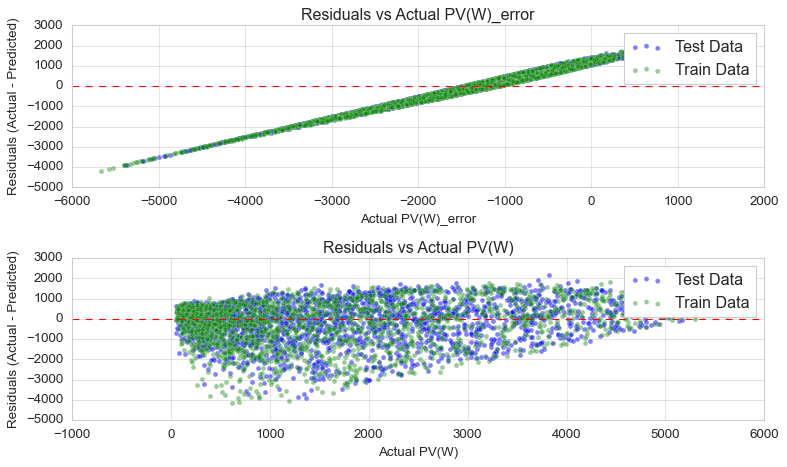

In [44]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()




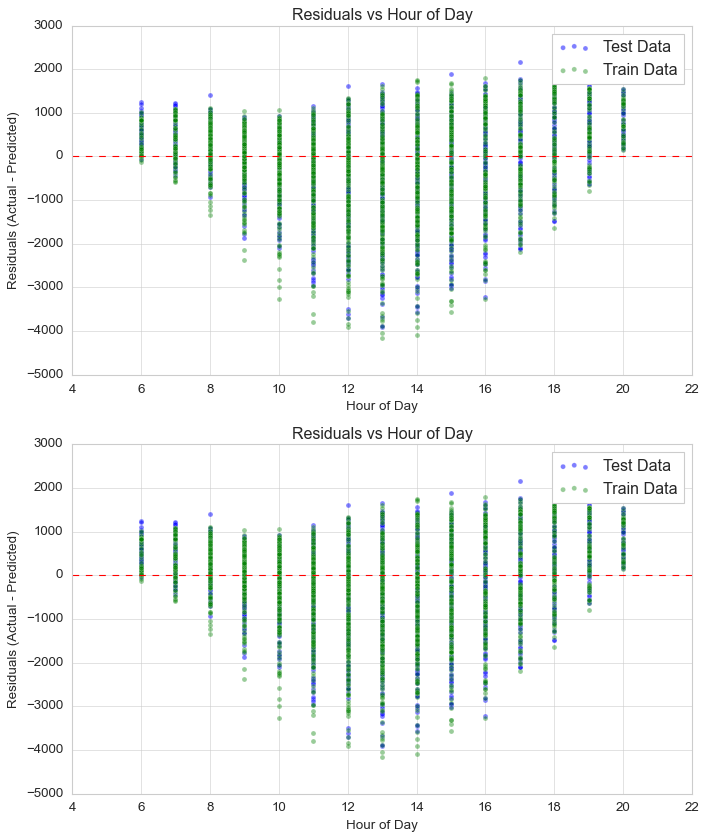

In [45]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

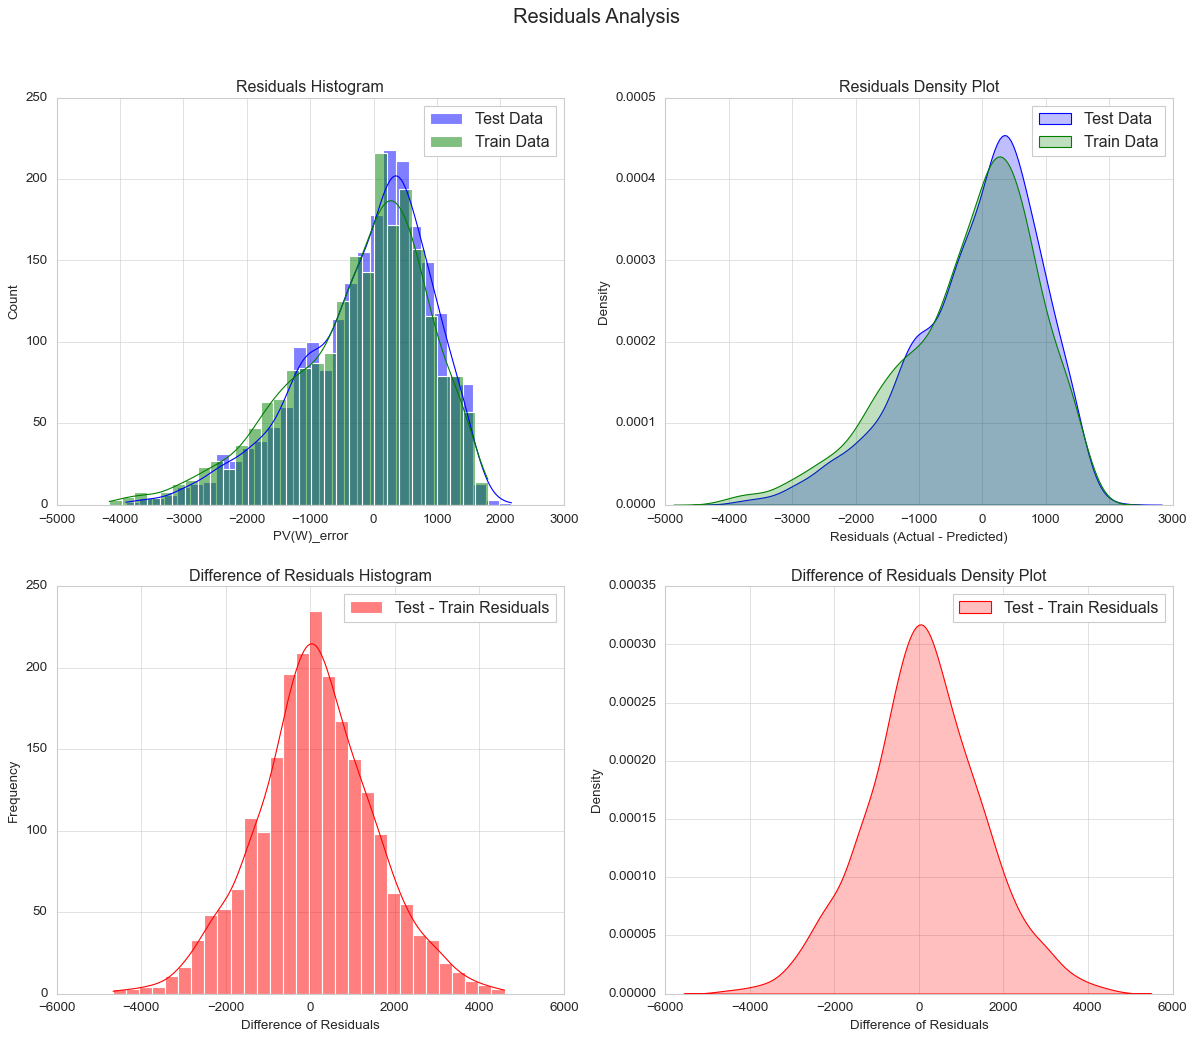

In [46]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

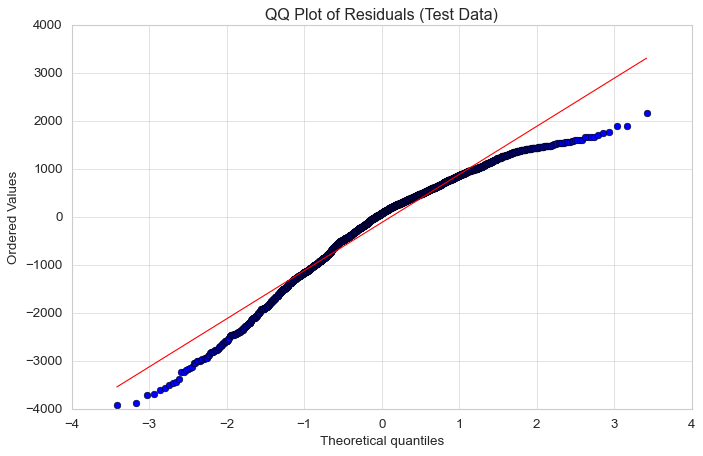

In [47]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


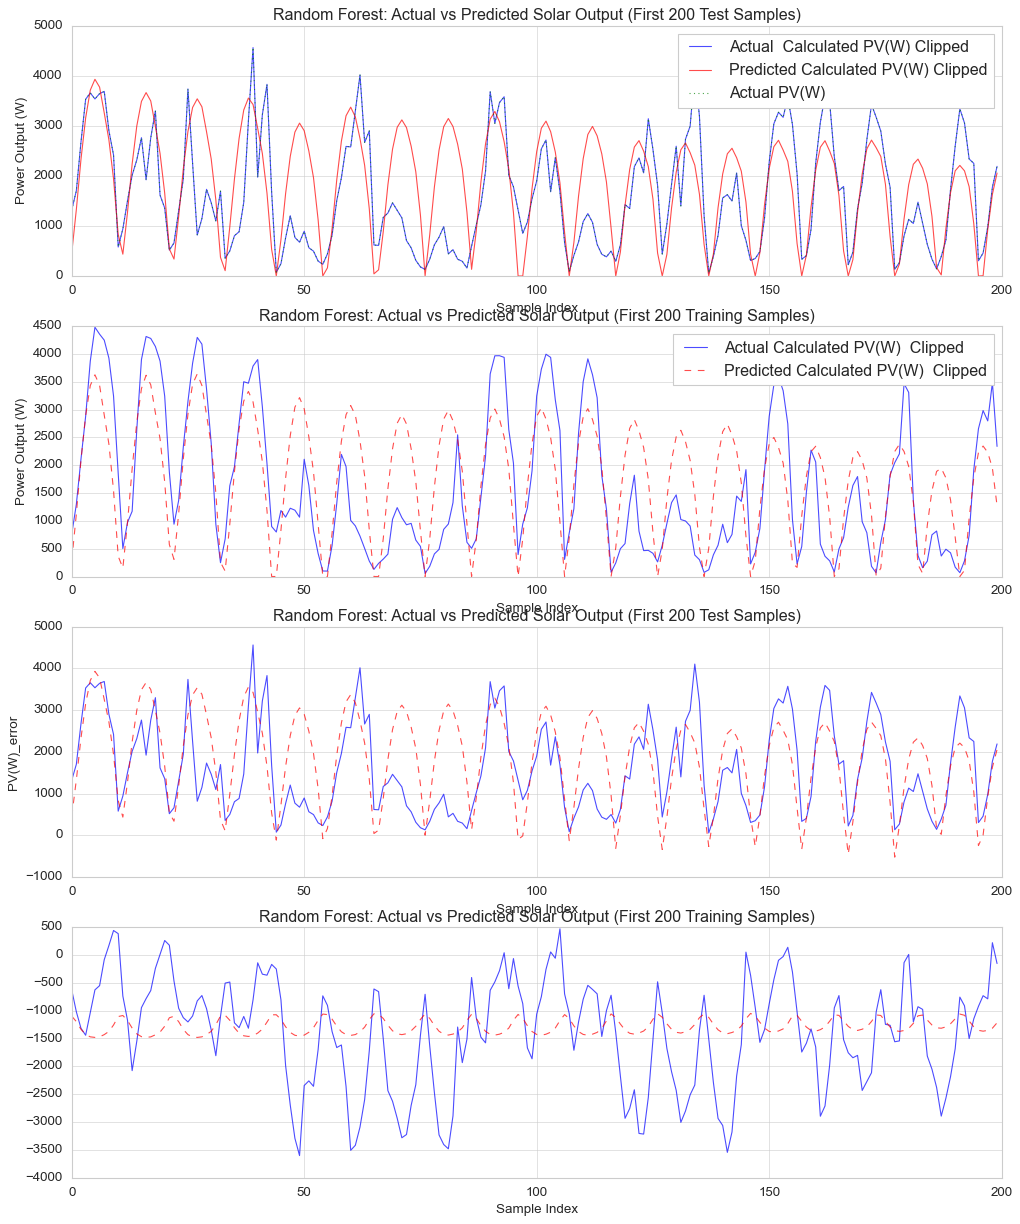

In [48]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

This is too to investigate if using the media as an alternative to mean gives a beter result.


Note: Gemini Prompt to generate the code

Write results to CSV file

In [49]:
with open(f'results/svr_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/svr_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("SVR Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}"  )
    line.append(f"{test_n_mae*100:.4f}"  )
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}"  )
    line.append(f"{train_n_mae*100:.4f}"  )
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}"  )
    line.append(f"{test_n_mae_pvw*100:.4f}"  )
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}"  )
    line.append(f"{train_n_mae_pvw*100:.4f}"  )
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')